# DPPUv2 Paper Figures

**Purpose:** Generate publication-ready figures for the DPPUv2 research paper.

**Generated Figures:**
- Cell 7-8: Physical Scaling Laws (r₀ ~ 1/V and Depth ~ 1/V)
- Cell 10-11: Potential Decomposition (Term-by-Term Analysis)
- Cell 13-14: Nieh-Yan Variant Comparison (FULL vs TT-only vs Ree-only)

**Requirements:**
- Python 3.10+
- SymPy, NumPy, Matplotlib
- DPPUv2 Engine Core v3.0

**Author:** Muacca  
**Date:** 2025-12-31

## Setup Section

In [ ]:
# Cell 3: Imports & Configuration
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import sys
import os

# Style configuration
try:
    import scienceplots
    plt.style.use(['science', 'notebook', 'grid'])
except ImportError:
    print("scienceplots not available, using default style")
    plt.style.use('seaborn-v0_8-whitegrid')

# Publication-quality settings
plt.rcParams.update({
    'figure.dpi': 150,           # Display quality
    'savefig.dpi': 300,          # Output quality
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.titlesize': 14,
})

# Physical constants (Planck units)
KAPPA = 1.0
L_SCALE = 1.0

print("Setup complete.")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Setup complete.
NumPy version: 2.3.5
Matplotlib version: 3.10.7


In [ ]:
# Cell 4: Engine Loading
import warnings
warnings.filterwarnings('ignore')

try:
    from DPPUv2_engine_core_v3 import Mode, NyVariant
    from DPPUv2_runner_S3S1_v3 import S3S1Engine
    from DPPUv2_runner_Nil3S1_v3 import Nil3S1Engine
    from DPPUv2_runner_T3S1_v3 import T3S1Engine
    print("✓ Engines imported successfully")
except ImportError as e:
    print(f"✗ Error importing engines: {e}")
    raise

def generate_engine(engine_class, mode=Mode.MX, ny_variant=NyVariant.FULL, apply_isotropy_fix=False):
    """
    Generate and run engine instance.
    
    Args:
        engine_class: S3S1Engine, Nil3S1Engine, or T3S1Engine
        mode: Torsion mode (default: MX)
        ny_variant: Nieh-Yan variant (default: FULL)
        apply_isotropy_fix: For T3, force R2=R3=r (default: False)
    
    Returns:
        engine: The engine instance with computed potential
    """
    # Suppress engine output
    original_stdout = sys.stdout
    try:
        sys.stdout = open(os.devnull, 'w')
        engine = engine_class(mode=mode, ny_variant=ny_variant)
        engine.run()
        
        # Apply isotropy fix for T3 if requested
        if apply_isotropy_fix and engine_class.__name__ == 'T3S1Engine':
            params = engine.data['params']
            if 'R2' in params and 'R3' in params:
                r_sym = params['r']
                R2_sym = params['R2']
                R3_sym = params['R3']
                engine.data['potential'] = engine.data['potential'].subs({R2_sym: r_sym, R3_sym: r_sym})
    finally:
        sys.stdout.close()
        sys.stdout = original_stdout
    
    return engine

# Store engines for decomposition access
engines = {}

print("\nGenerating engines and potential functions...")
print("[1/9] S3 × FULL")
engines['S3_FULL'] = generate_engine(S3S1Engine, ny_variant=NyVariant.FULL)
func_s3_full = engines['S3_FULL'].get_effective_potential_function()

print("[2/9] S3 × TT")
engines['S3_TT'] = generate_engine(S3S1Engine, ny_variant=NyVariant.TT)
func_s3_tt = engines['S3_TT'].get_effective_potential_function()

print("[3/9] S3 × REE")
engines['S3_REE'] = generate_engine(S3S1Engine, ny_variant=NyVariant.REE)
func_s3_ree = engines['S3_REE'].get_effective_potential_function()

print("[4/9] Nil3 × FULL")
engines['Nil3_FULL'] = generate_engine(Nil3S1Engine, ny_variant=NyVariant.FULL)
func_nil3_full = engines['Nil3_FULL'].get_effective_potential_function()

print("[5/9] Nil3 × TT")
engines['Nil3_TT'] = generate_engine(Nil3S1Engine, ny_variant=NyVariant.TT)
func_nil3_tt = engines['Nil3_TT'].get_effective_potential_function()

print("[6/9] Nil3 × REE")
engines['Nil3_REE'] = generate_engine(Nil3S1Engine, ny_variant=NyVariant.REE)
func_nil3_ree = engines['Nil3_REE'].get_effective_potential_function()

print("[7/9] T3 × FULL")
engines['T3_FULL'] = generate_engine(T3S1Engine, ny_variant=NyVariant.FULL, apply_isotropy_fix=True)
func_t3_full = engines['T3_FULL'].get_effective_potential_function()

print("[8/9] T3 × TT")
engines['T3_TT'] = generate_engine(T3S1Engine, ny_variant=NyVariant.TT, apply_isotropy_fix=True)
func_t3_tt = engines['T3_TT'].get_effective_potential_function()

print("[9/9] T3 × REE")
engines['T3_REE'] = generate_engine(T3S1Engine, ny_variant=NyVariant.REE, apply_isotropy_fix=True)
func_t3_ree = engines['T3_REE'].get_effective_potential_function()

print("\n✓ All engines and potential functions generated successfully")
print(f"  Engines stored: {list(engines.keys())}")

✓ Engines imported successfully

Generating engines and potential functions...
[1/9] S3 × FULL
[2/9] S3 × TT
[3/9] S3 × REE
[4/9] Nil3 × FULL
[5/9] Nil3 × TT
[6/9] Nil3 × REE
[7/9] T3 × FULL
[8/9] T3 × TT
[9/9] T3 × REE

✓ All engines and potential functions generated successfully
  Engines stored: ['S3_FULL', 'S3_TT', 'S3_REE', 'Nil3_FULL', 'Nil3_TT', 'Nil3_REE', 'T3_FULL', 'T3_TT', 'T3_REE']


In [ ]:
# Cell 5: Helper Functions

def wrap_potential(func):
    """Wrapper to provide consistent interface."""
    def wrapped(r, V, eta, theta_NY):
        return func(r, V, eta, theta_NY, L_SCALE, KAPPA)
    return wrapped

# Wrapped functions with consistent interface
V_S3_FULL = wrap_potential(func_s3_full)
V_S3_TT = wrap_potential(func_s3_tt)
V_S3_REE = wrap_potential(func_s3_ree)

V_Nil3_FULL = wrap_potential(func_nil3_full)
V_Nil3_TT = wrap_potential(func_nil3_tt)
V_Nil3_REE = wrap_potential(func_nil3_ree)

V_T3_FULL = wrap_potential(func_t3_full)
V_T3_TT = wrap_potential(func_t3_tt)
V_T3_REE = wrap_potential(func_t3_ree)

def find_stable_radius(V_func, V_param, eta, theta, r_min=0.01, r_max=50.0, n_points=2000):
    """
    Find stable radius (local minimum) of potential.
    
    Returns:
        r0: Stable radius (None if no minimum found)
        V_min: Potential at minimum
        is_type_I: True if Type-I (barrier + well), False if Type-II (rolling)
    """
    r_test = np.linspace(r_min, r_max, n_points)
    V_profile = V_func(r_test, V_param, eta, theta)
    
    # Find minimum
    min_idx = np.argmin(V_profile)
    
    # Check if it's a local minimum (not at boundaries)
    if 0 < min_idx < len(r_test) - 1:
        is_local_min = (V_profile[min_idx-1] > V_profile[min_idx] < V_profile[min_idx+1])
        is_deep_well = V_profile[min_idx] < V_profile[-1]  # Lower than asymptotic value
        
        if is_local_min and is_deep_well:
            r0 = r_test[min_idx]
            V_min = V_profile[min_idx]
            
            # Determine if Type-I (barrier) or Type-II (rolling)
            # Type-I: V increases from r=0 toward minimum
            # Type-II: V decreases from r=0 toward minimum
            V_origin = V_func(r_min, V_param, eta, theta)
            is_type_I = V_origin > V_min
            
            return r0, V_min, is_type_I
    
    return None, None, None

print("✓ Helper functions defined")

✓ Helper functions defined


## Physical Scaling Laws

**Purpose:** Demonstrates that both stable radius r₀ and potential depth scale as 1/V, confirming theoretical predictions across all three topologies.

**Parameters:**
- η = -7.0 (axial torsion for stability)
- θ_NY = 2.0 (Nieh-Yan coupling)
- V scan range: 0.5 → 6.0

**Expected Output:** 3 separate figures (one per topology):
- Scaling_laws_S3.png/pdf: S³×S¹ scaling laws
- Scaling_laws_Nil3.png/pdf: Nil³×S¹ scaling laws
- Scaling_laws_T3.png/pdf: T³×S¹ scaling laws

Each figure shows:
- Left panel: r₀ vs V (inverse relationship)
- Right panel: log(Depth) vs log(V) (slope ≈ -1)

In [ ]:
# Cell 7: Calculate Scaling Data for All Topologies
print("Calculating scaling laws for all topologies...")

# Common parameters (stable across all topologies)
eta_scaling = -7.0
theta_scaling = 2.0

# V scan range
v_scan = np.linspace(0.5, 6.0, 50)

# Topology configurations
topology_configs = {
    'S3': {'func': V_S3_FULL, 'label': r'S$^3\times$S$^1$'},
    'Nil3': {'func': V_Nil3_FULL, 'label': r'Nil$^3\times$S$^1$'},
    'T3': {'func': V_T3_FULL, 'label': r'T$^3\times$S$^1$'}
}

# Store scaling data for each topology
all_scaling_data = {}

for topo_key, config in topology_configs.items():
    print(f"\n  Processing {config['label']}...")
    
    r0_list = []
    v_min_list = []
    valid_v = []
    
    # Scan over V values
    for i, val in enumerate(v_scan):
        result = find_stable_radius(config['func'], val, eta_scaling, theta_scaling)
        
        if result[0] is not None:
            r0, v_min, is_type_I = result
            r0_list.append(r0)
            v_min_list.append(v_min)
            valid_v.append(val)
    
    if not valid_v:
        print(f"    ✗ No stable regions found for {topo_key}")
        all_scaling_data[topo_key] = None
        continue
    
    print(f"    ✓ Found {len(valid_v)} stable configurations")
    
    V_arr = np.array(valid_v)
    r0_arr = np.array(r0_list)
    depth_arr = np.abs(np.array(v_min_list))
    
    # Analytical fits
    # 1. Radius: r0 ~ C_r / V
    C_r = np.mean(r0_arr * V_arr)
    r0_analytical = C_r / V_arr
    print(f"    Radius scaling constant: C_r = {C_r:.3f}")
    
    # 2. Depth: Depth ~ C_d / V (anchored to first point)
    C_d = depth_arr[0] * V_arr[0]
    depth_analytical = C_d / V_arr
    print(f"    Depth scaling constant: C_d = {C_d:.3e}")
    
    all_scaling_data[topo_key] = {
        'V': V_arr,
        'r0': r0_arr,
        'depth': depth_arr,
        'r0_fit': r0_analytical,
        'depth_fit': depth_analytical,
        'C_r': C_r,
        'C_d': C_d,
        'label': config['label']
    }

print("\n✓ Scaling data calculated for all topologies")

Calculating scaling laws for all topologies...

  Processing S$^3\times$S$^1$...
    ✓ Found 38 stable configurations
    Radius scaling constant: C_r = 87.826
    Depth scaling constant: C_d = 2.216e+06

  Processing Nil$^3\times$S$^1$...
    ✓ Found 45 stable configurations
    Radius scaling constant: C_r = 50.134
    Depth scaling constant: C_d = 2.648e+07

  Processing T$^3\times$S$^1$...
    ✓ Found 44 stable configurations
    Radius scaling constant: C_r = 53.235
    Depth scaling constant: C_d = 3.310e+07

✓ Scaling data calculated for all topologies


✓ S$^3\times$S$^1$ scaling laws saved: Scaling_laws_S3.png/pdf


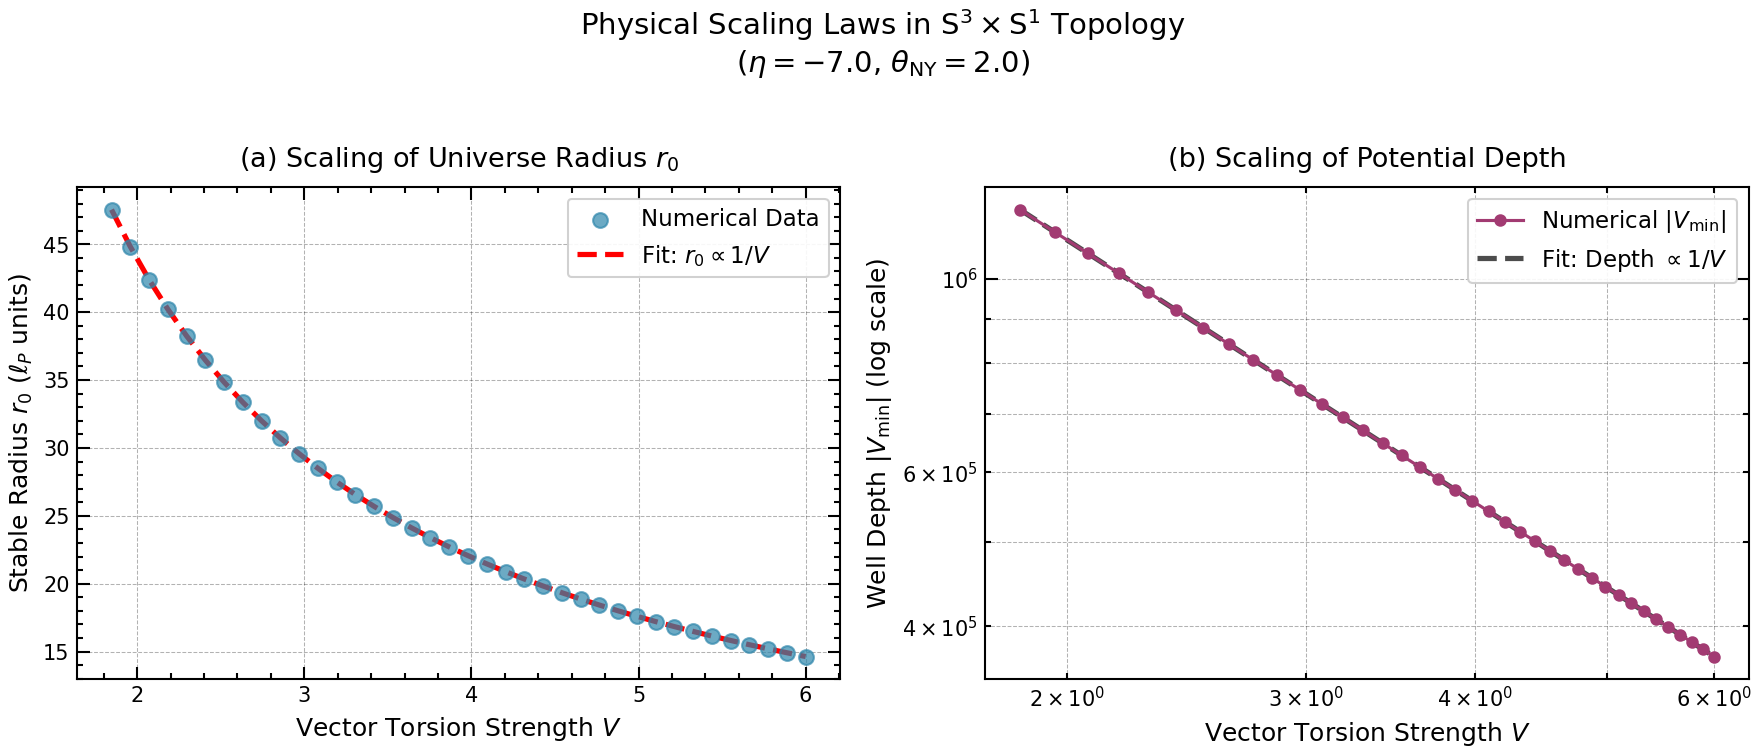

✓ Nil$^3\times$S$^1$ scaling laws saved: Scaling_laws_Nil3.png/pdf


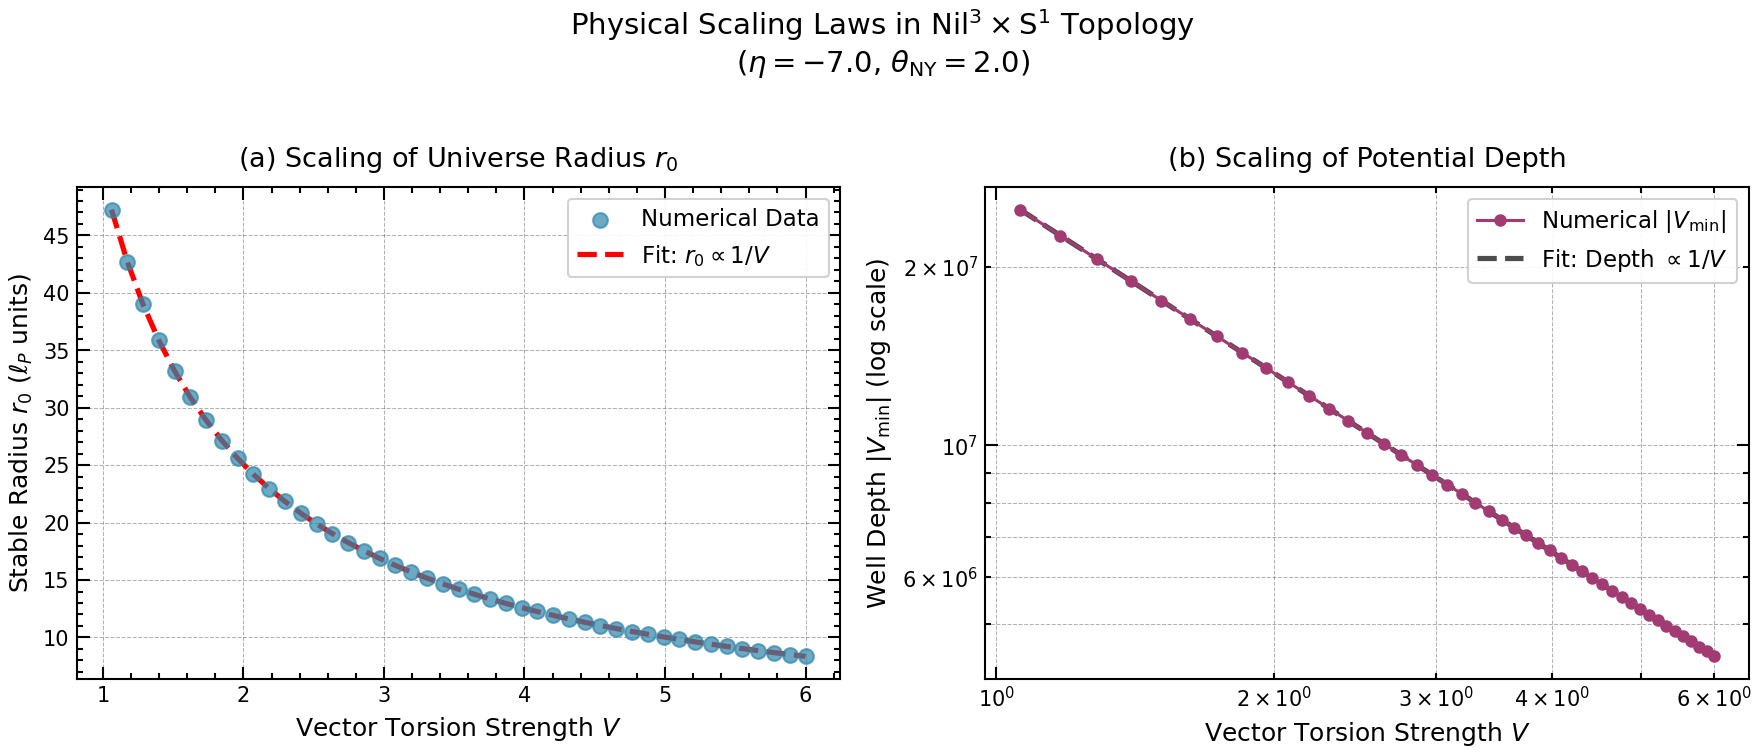

✓ T$^3\times$S$^1$ scaling laws saved: Scaling_laws_T3.png/pdf


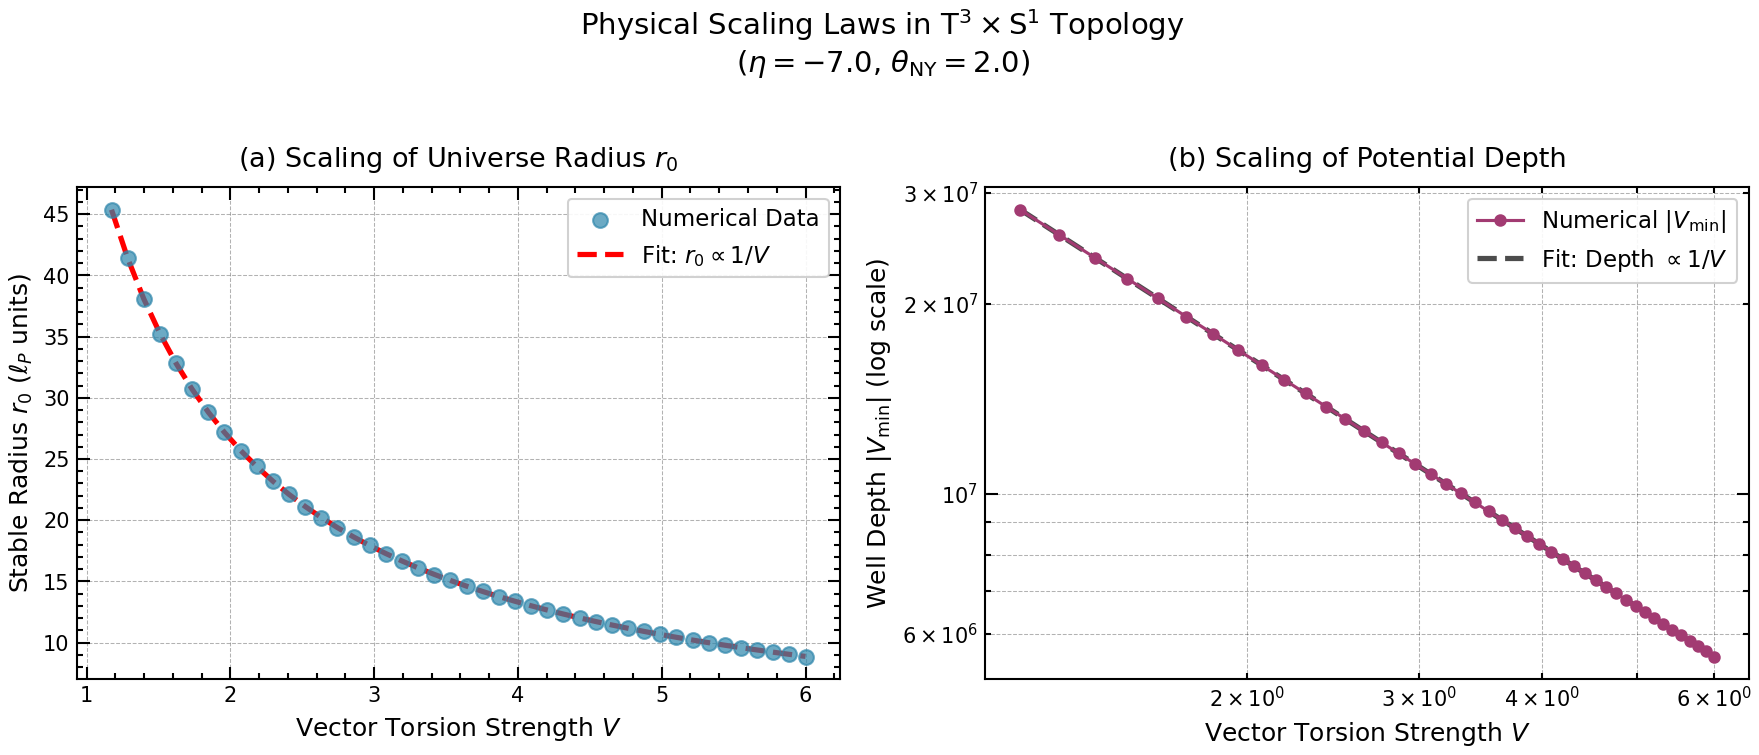


✓ All Scaling Laws figures generated


In [ ]:
# Cell 8: Generate Scaling Laws (Separate Figures per Topology)

file_names = {
    'S3': 'Scaling_laws_S3',
    'Nil3': 'Scaling_laws_Nil3',
    'T3': 'Scaling_laws_T3'
}

for topo_key, data in all_scaling_data.items():
    if data is None:
        print(f"✗ Skipping {topo_key}: No stable data")
        continue
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left panel: Radius scaling
    ax1.scatter(data['V'], data['r0'], 
               c='#2E86AB', alpha=0.7, s=50, label='Numerical Data', zorder=3)
    ax1.plot(data['V'], data['r0_fit'], 
            'r--', linewidth=2.5, label=r'Fit: $r_0 \propto 1/V$', zorder=2)
    
    ax1.set_title(r"(a) Scaling of Universe Radius $r_0$", fontsize=13, pad=10)
    ax1.set_xlabel(r"Vector Torsion Strength $V$", fontsize=12)
    ax1.set_ylabel(r"Stable Radius $r_0$ ($\ell_P$ units)", fontsize=12)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(fontsize=11, framealpha=0.9)
    
    # Right panel: Depth scaling (log-log)
    ax2.loglog(data['V'], data['depth'], 
              'o-', color='#A23B72', markersize=5, linewidth=1.5, 
              label=r'Numerical $|V_{\mathrm{min}}|$', zorder=3)
    ax2.loglog(data['V'], data['depth_fit'], 
              'k--', alpha=0.7, linewidth=2.5, 
              label=r'Fit: Depth $\propto 1/V$', zorder=2)
    
    ax2.set_title(r"(b) Scaling of Potential Depth", fontsize=13, pad=10)
    ax2.set_xlabel(r"Vector Torsion Strength $V$", fontsize=12)
    ax2.set_ylabel(r"Well Depth $|V_{\mathrm{min}}|$ (log scale)", fontsize=12)
    ax2.grid(True, which="both", alpha=0.3, linestyle='--')
    ax2.legend(fontsize=11, framealpha=0.9)
    
    plt.suptitle(f"Physical Scaling Laws in {data['label']} Topology\n" +
                r"($\eta=-7.0$, $\theta_{\mathrm{NY}}=2.0$)", 
                fontsize=14, y=1.02)
    plt.tight_layout()
    
    # Save
    fig.savefig(f'{file_names[topo_key]}.png', dpi=300, bbox_inches='tight')
    fig.savefig(f'{file_names[topo_key]}.pdf', bbox_inches='tight')
    
    print(f"✓ {data['label']} scaling laws saved: {file_names[topo_key]}.png/pdf")
    plt.show()

print("\n✓ All Scaling Laws figures generated")

## Potential Decomposition (Term-by-Term Analysis)

**Purpose:** Demonstrates effective potential shapes across the three topologies with term-by-term decomposition.

**Parameters:** (共通パラメータ)
- V = 4.0, η = -7.0, θ_NY = 2.0

**Expected Output:** 3 separate figures (one per topology):
- decomposition_S3.png/pdf: S³×S¹ potential decomposition
- decomposition_Nil3.png/pdf: Nil³×S¹ potential decomposition
- decomposition_T3.png/pdf: T³×S¹ potential decomposition

Each figure shows decomposed terms (V², V·η·θ, η²+const) and total potential.
Axis ranges are automatically adjusted to include stable points.

In [ ]:
# Cell 10: Calculate r-V Profiles with Term Decomposition (using Engine API)
print("Calculating r-V profiles with term-by-term decomposition...")
print("  Using engine.get_potential_term_functions() API")

# Shared parameters (same as Scaling Laws and Variant Comparison)
V_comp = 4.0
eta_comp = -7.0
theta_comp = 2.0

# Radius range (wide range for stable point detection)
r_range = np.linspace(0.1, 50.0, 2000)

# Get term decomposition functions from engines
def get_decomposed_terms(engine, r_arr, V_param, eta_param, theta_param):
    """
    Get decomposed potential terms from engine using new API.
    
    Returns:
        dict: {'total': array, 'vector': array, 'ny': array, 'curv': array}
    """
    term_funcs = engine.get_potential_term_functions()
    
    return {
        'total': term_funcs['total'](r_arr, V_param, eta_param, theta_param, L_SCALE, KAPPA),
        'vector': term_funcs['r^3'](r_arr, V_param, eta_param, theta_param, L_SCALE, KAPPA),
        'ny': term_funcs['r^2'](r_arr, V_param, eta_param, theta_param, L_SCALE, KAPPA),
        'curv': term_funcs['r^1'](r_arr, V_param, eta_param, theta_param, L_SCALE, KAPPA),
    }

# ========== S³×S¹ Decomposition (from engine) ==========
print("  Decomposing S³×S¹...")
s3_terms = get_decomposed_terms(engines['S3_FULL'], r_range, V_comp, eta_comp, theta_comp)
V_s3_total = s3_terms['total']
V_s3_vector = s3_terms['vector']
V_s3_ny = s3_terms['ny']
V_s3_curv = s3_terms['curv']

# ========== Nil³×S¹ Decomposition (from engine) ==========
print("  Decomposing Nil³×S¹...")
nil3_terms = get_decomposed_terms(engines['Nil3_FULL'], r_range, V_comp, eta_comp, theta_comp)
V_nil3_total = nil3_terms['total']
V_nil3_vector = nil3_terms['vector']
V_nil3_ny = nil3_terms['ny']
V_nil3_curv = nil3_terms['curv']

# ========== T³×S¹ Decomposition (from engine) ==========
print("  Decomposing T³×S¹...")
t3_terms = get_decomposed_terms(engines['T3_FULL'], r_range, V_comp, eta_comp, theta_comp)
V_t3_total = t3_terms['total']
V_t3_vector = t3_terms['vector']
V_t3_ny = t3_terms['ny']
V_t3_curv = t3_terms['curv']

# Find stable radii
s3_result = find_stable_radius(V_S3_FULL, V_comp, eta_comp, theta_comp)
nil3_result = find_stable_radius(V_Nil3_FULL, V_comp, eta_comp, theta_comp)
t3_result = find_stable_radius(V_T3_FULL, V_comp, eta_comp, theta_comp)

print(f"  S³×S¹: r₀ = {s3_result[0]:.3f} (Type-{'I' if s3_result[2] else 'II'})" if s3_result[0] else "  S³×S¹: No stable radius")
print(f"  Nil³×S¹: r₀ = {nil3_result[0]:.3f} (Type-{'I' if nil3_result[2] else 'II'})" if nil3_result[0] else "  Nil³×S¹: No stable radius")
print(f"  T³×S¹: r₀ = {t3_result[0]:.3f} (Type-{'I' if t3_result[2] else 'II'})" if t3_result[0] else "  T³×S¹: No stable radius")

comparison_data = {
    'r': r_range,
    'S3': {
        'total': V_s3_total,
        'vector': V_s3_vector,
        'ny': V_s3_ny,
        'curv': V_s3_curv,
        'r0': s3_result[0],
        'V_min': s3_result[1]
    },
    'Nil3': {
        'total': V_nil3_total,
        'vector': V_nil3_vector,
        'ny': V_nil3_ny,
        'curv': V_nil3_curv,
        'r0': nil3_result[0],
        'V_min': nil3_result[1]
    },
    'T3': {
        'total': V_t3_total,
        'vector': V_t3_vector,
        'ny': V_t3_ny,
        'curv': V_t3_curv,
        'r0': t3_result[0],
        'V_min': t3_result[1]
    }
}

print("✓ r-V profiles with decomposition calculated (via engine API)")

Calculating r-V profiles with term-by-term decomposition...
  Using engine.get_potential_term_functions() API
  Decomposing S³×S¹...
  Decomposing Nil³×S¹...
  Decomposing T³×S¹...
  S³×S¹: r₀ = 21.967 (Type-I)
  Nil³×S¹: r₀ = 12.539 (Type-I)
  T³×S¹: r₀ = 13.314 (Type-I)
✓ r-V profiles with decomposition calculated (via engine API)


✓ S$^3\times$S$^1$ decomposition saved: decomposition_S3.png/pdf
    Display range: x=[0, 40.0], r₀=21.97


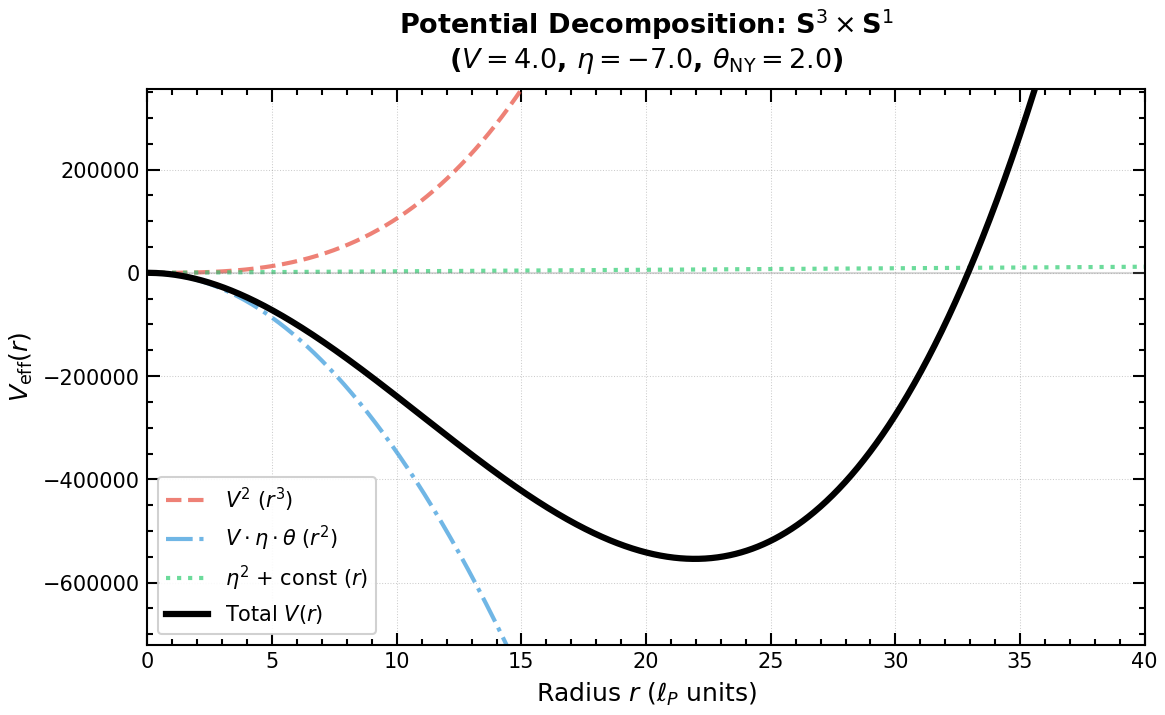

✓ Nil$^3\times$S$^1$ decomposition saved: decomposition_Nil3.png/pdf
    Display range: x=[0, 31.3], r₀=12.54


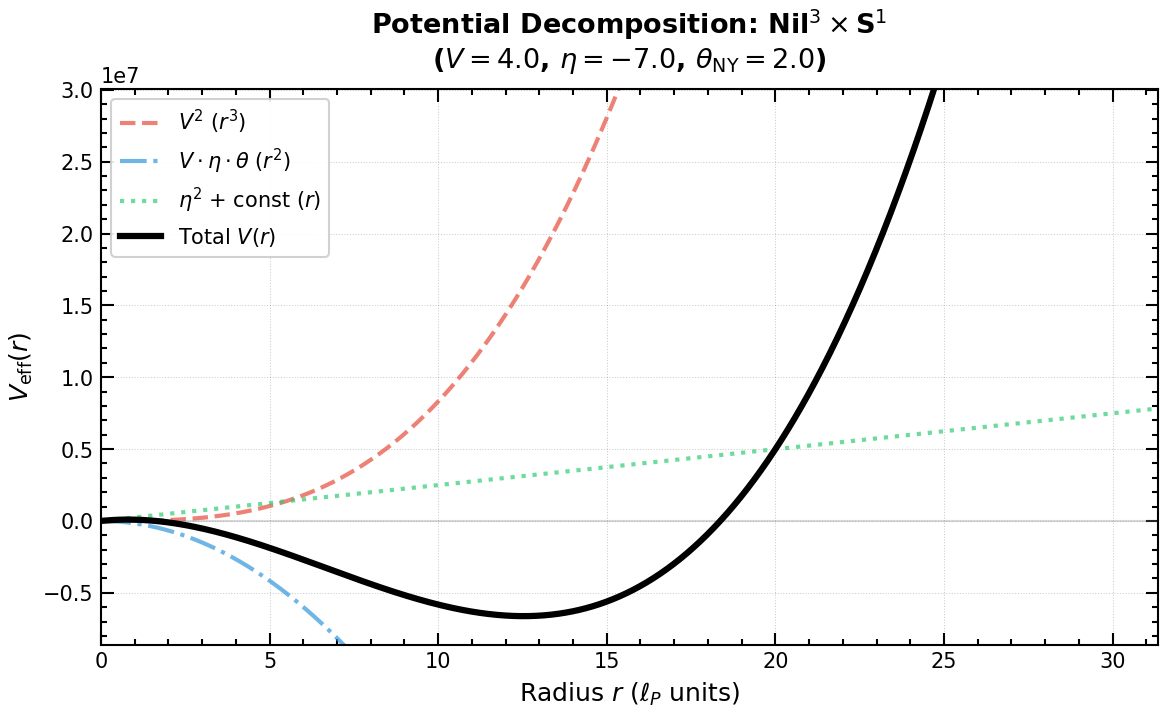

✓ T$^3\times$S$^1$ decomposition saved: decomposition_T3.png/pdf
    Display range: x=[0, 33.3], r₀=13.31


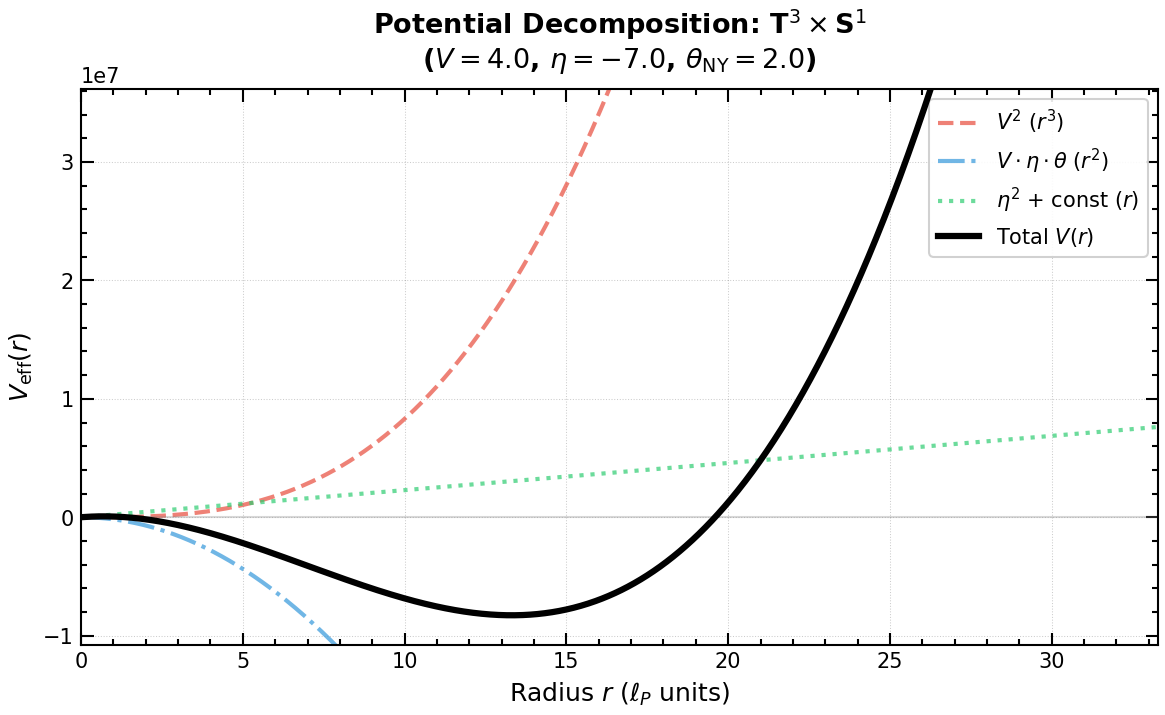

In [ ]:
# Cell 11: Generate r-V Profiles with Term Decomposition (Separate Figures)

# Color scheme for decomposition
term_styles = {
    'vector': {'color': '#E74C3C', 'linestyle': '--', 'label': r'$V^2$', 'linewidth': 2},
    'ny': {'color': '#3498DB', 'linestyle': '-.', 'label': r'$V \cdot \eta \cdot \theta$', 'linewidth': 2},
    'curv': {'color': '#2ECC71', 'linestyle': ':', 'label': r'$\eta^2$ + const', 'linewidth': 2}
}

topology_labels = {
    'S3': r'S$^3\times$S$^1$',
    'Nil3': r'Nil$^3\times$S$^1$',
    'T3': r'T$^3\times$S$^1$'
}

# Power labels for each topology (r-dependence)
power_labels = {
    'S3': {'vector': r'$r^3$', 'ny': r'$r^2$', 'curv': r'$r$'},
    'Nil3': {'vector': r'$r^3$', 'ny': r'$r^2$', 'curv': r'$r$'},
    'T3': {'vector': r'$r^3$', 'ny': r'$r^2$', 'curv': r'$r$'}
}

# File name mapping
file_names = {
    'S3': 'decomposition_S3',
    'Nil3': 'decomposition_Nil3',
    'T3': 'decomposition_T3'
}

topologies = ['S3', 'Nil3', 'T3']

for topo in topologies:
    fig, ax = plt.subplots(figsize=(8, 5))
    data = comparison_data[topo]
    
    # Determine axis limits based on stable point
    r0 = data['r0']
    V_min = data['V_min']
    
    if r0 is not None:
        # Set x range: 0 to 2.5 * r0 (show stable point with context)
        x_max = min(r0 * 2.5, 40.0)
        
        # Find y range within x range
        mask = comparison_data['r'] <= x_max
        r_display = comparison_data['r'][mask]
        total_display = data['total'][mask]
        
        # y range: include minimum with margin
        y_min = V_min * 1.3 if V_min < 0 else V_min * 0.7
        y_max = max(total_display[0], total_display[-1]) * 0.3  # Upper margin
        if y_max < 0:
            y_max = abs(V_min) * 0.5
    else:
        x_max = 20.0
        y_min, y_max = None, None  # Auto
    
    # Plot decomposed terms first (background)
    ax.plot(comparison_data['r'], data['vector'], 
           color=term_styles['vector']['color'], 
           linestyle=term_styles['vector']['linestyle'],
           linewidth=term_styles['vector']['linewidth'],
           alpha=0.7,
           label=term_styles['vector']['label'] + f" ({power_labels[topo]['vector']})")
    
    ax.plot(comparison_data['r'], data['ny'], 
           color=term_styles['ny']['color'], 
           linestyle=term_styles['ny']['linestyle'],
           linewidth=term_styles['ny']['linewidth'],
           alpha=0.7,
           label=term_styles['ny']['label'] + f" ({power_labels[topo]['ny']})")
    
    ax.plot(comparison_data['r'], data['curv'], 
           color=term_styles['curv']['color'], 
           linestyle=term_styles['curv']['linestyle'],
           linewidth=term_styles['curv']['linewidth'],
           alpha=0.7,
           label=term_styles['curv']['label'] + f" ({power_labels[topo]['curv']})")
    
    # Plot total potential (foreground)
    ax.plot(comparison_data['r'], data['total'], 
           color='#000000', linewidth=3, 
           label=r'Total $V(r)$', zorder=10)
    
    ax.axhline(0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
    ax.set_xlabel(r"Radius $r$ ($\ell_P$ units)", fontsize=12)
    ax.set_ylabel(r"$V_{\mathrm{eff}}(r)$", fontsize=12)
    ax.set_title(f"Potential Decomposition: {topology_labels[topo]}\n" + 
                r"($V=4.0$, $\eta=-7.0$, $\theta_{\mathrm{NY}}=2.0$)",
                fontsize=13, pad=10, fontweight='bold')
    ax.grid(True, alpha=0.2, linestyle=':')
    ax.legend(fontsize=10, loc='best', framealpha=0.9)
    
    # Apply axis limits
    ax.set_xlim(0, x_max)
    if y_min is not None and y_max is not None:
        ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    
    # Save
    fig.savefig(f'{file_names[topo]}.png', dpi=300, bbox_inches='tight')
    fig.savefig(f'{file_names[topo]}.pdf', bbox_inches='tight')
    
    print(f"✓ {topology_labels[topo]} decomposition saved: {file_names[topo]}.png/pdf")
    print(f"    Display range: x=[0, {x_max:.1f}], r₀={r0:.2f}" if r0 else f"    Display range: x=[0, {x_max:.1f}], no stable point")
    plt.show()

## Nieh-Yan Variant Comparison

**Purpose:** Demonstrates that the FULL definition (TT - Ree) is essential for stabilization, while TT-only and Ree-only variants show qualitatively different behaviors.

**Parameters:** (共通パラメータ)
- V = 4.0, η = -7.0, θ_NY = 2.0
- Three variants: FULL, TT-only, Ree-only

**Expected Output:** 3 separate figures (one per topology):
- variant_comparison_S3.png/pdf: S³×S¹ variant comparison
- variant_comparison_Nil3.png/pdf: Nil³×S¹ variant comparison
- variant_comparison_T3.png/pdf: T³×S¹ variant comparison

Each figure shows 3 NY variants overlaid on the same plot.

In [ ]:
# Cell 13: Calculate Variant Comparison Data
print("Calculating variant comparison profiles...")

# Parameters (same as Scaling Laws)
V_var = 4.0
eta_var = -7.0
theta_var = 2.0

# Wide range for stable point detection
r_var = np.linspace(0.1, 50.0, 2000)

# Calculate all 9 profiles
variant_data = {
    'S3': {
        'FULL': V_S3_FULL(r_var, V_var, eta_var, theta_var),
        'TT': V_S3_TT(r_var, V_var, eta_var, theta_var),
        'REE': V_S3_REE(r_var, V_var, eta_var, theta_var)
    },
    'Nil3': {
        'FULL': V_Nil3_FULL(r_var, V_var, eta_var, theta_var),
        'TT': V_Nil3_TT(r_var, V_var, eta_var, theta_var),
        'REE': V_Nil3_REE(r_var, V_var, eta_var, theta_var)
    },
    'T3': {
        'FULL': V_T3_FULL(r_var, V_var, eta_var, theta_var),
        'TT': V_T3_TT(r_var, V_var, eta_var, theta_var),
        'REE': V_T3_REE(r_var, V_var, eta_var, theta_var)
    }
}

# Debug: Check if FULL and REE are identical for T3
print("\n  [Debug] T³×S¹ variant comparison at r=5:")
r_idx = np.argmin(np.abs(r_var - 5.0))
print(f"    FULL(r=5) = {variant_data['T3']['FULL'][r_idx]:.6e}")
print(f"    TT(r=5)   = {variant_data['T3']['TT'][r_idx]:.6e}")
print(f"    REE(r=5)  = {variant_data['T3']['REE'][r_idx]:.6e}")
print(f"    FULL - REE = {variant_data['T3']['FULL'][r_idx] - variant_data['T3']['REE'][r_idx]:.6e}")
print(f"    TT - REE   = {variant_data['T3']['TT'][r_idx] - variant_data['T3']['REE'][r_idx]:.6e}")

# Find stable radii for FULL variant (for display range calculation)
variant_stability = {}
for topo in ['S3', 'Nil3', 'T3']:
    result = find_stable_radius(
        {'S3': V_S3_FULL, 'Nil3': V_Nil3_FULL, 'T3': V_T3_FULL}[topo],
        V_var, eta_var, theta_var
    )
    variant_stability[topo] = result
    if result[0]:
        print(f"  {topo} FULL: r₀ = {result[0]:.3f}, V_min = {result[1]:.3f}")
    else:
        print(f"  {topo} FULL: No stable radius")

print("✓ Variant comparison data calculated")

Calculating variant comparison profiles...

  [Debug] T³×S¹ variant comparison at r=5:
    FULL(r=5) = -2.172802e+06
    TT(r=5)   = -6.523902e+06
    REE(r=5)  = -2.172802e+06
    FULL - REE = 0.000000e+00
    TT - REE   = -4.351100e+06
  S3 FULL: r₀ = 21.967, V_min = -553980.334
  Nil3 FULL: r₀ = 12.539, V_min = -6619116.342
  T3 FULL: r₀ = 13.314, V_min = -8274614.486
✓ Variant comparison data calculated


✓ S$^3\times$S$^1$ variant comparison saved: variant_comparison_S3.png/pdf
    Display range: x=[0, 40.0], r₀=21.97


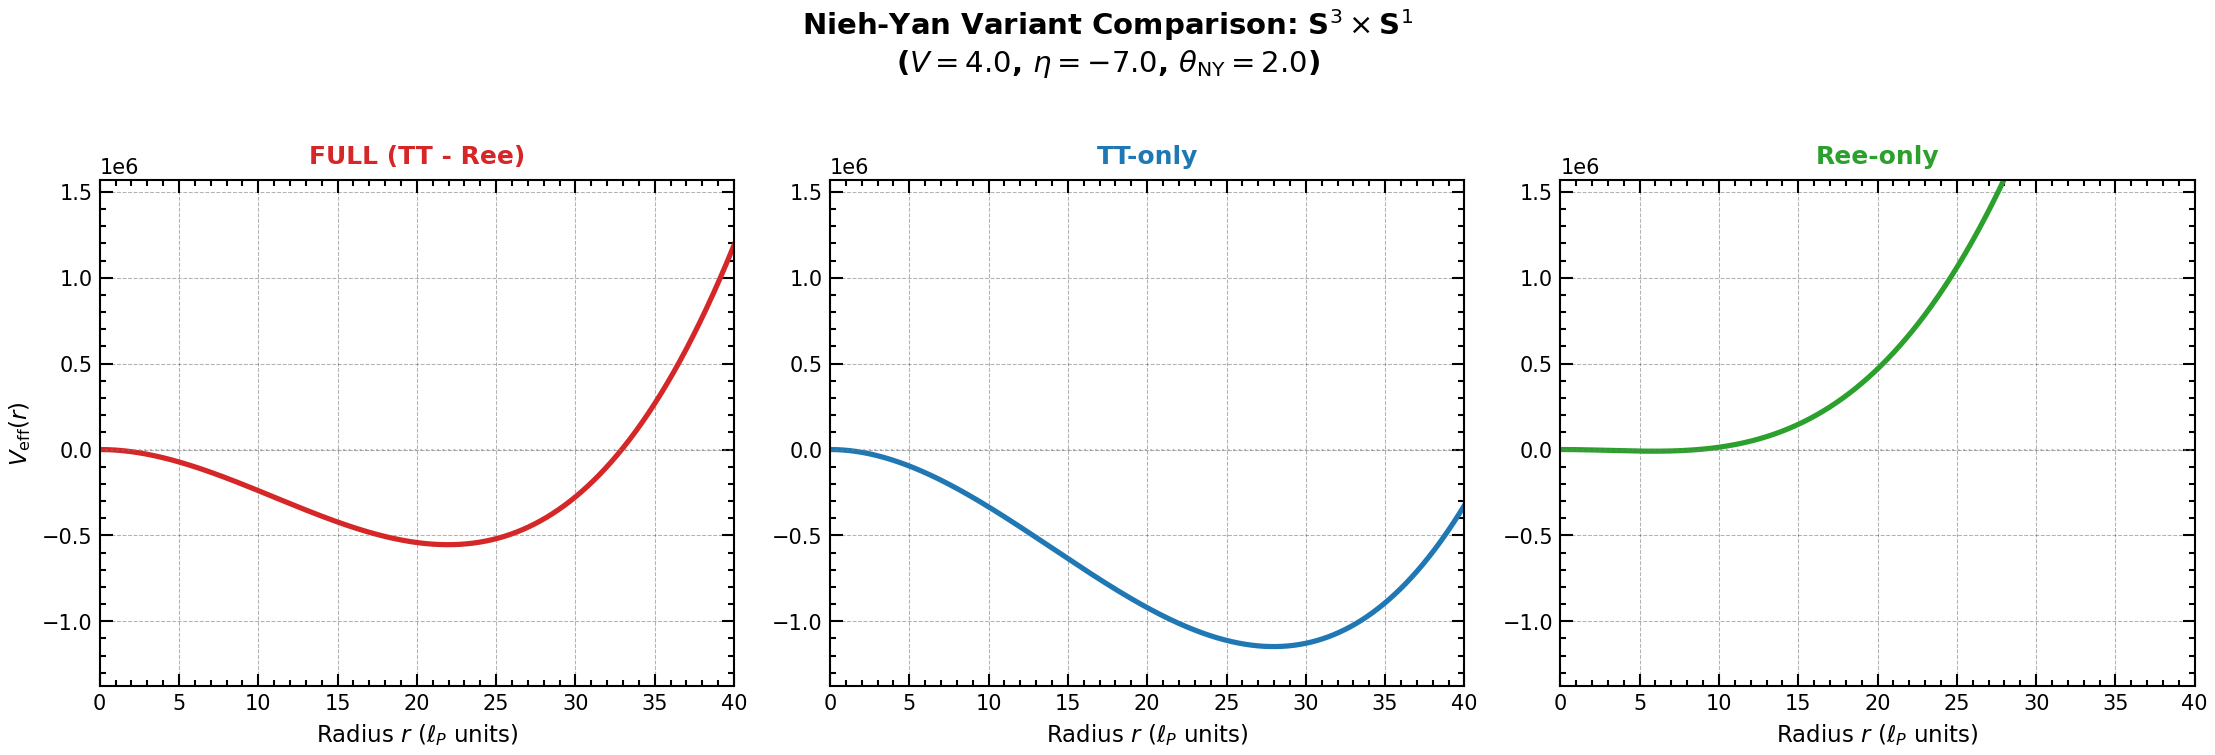

✓ Nil$^3\times$S$^1$ variant comparison saved: variant_comparison_Nil3.png/pdf
    Display range: x=[0, 31.3], r₀=12.54


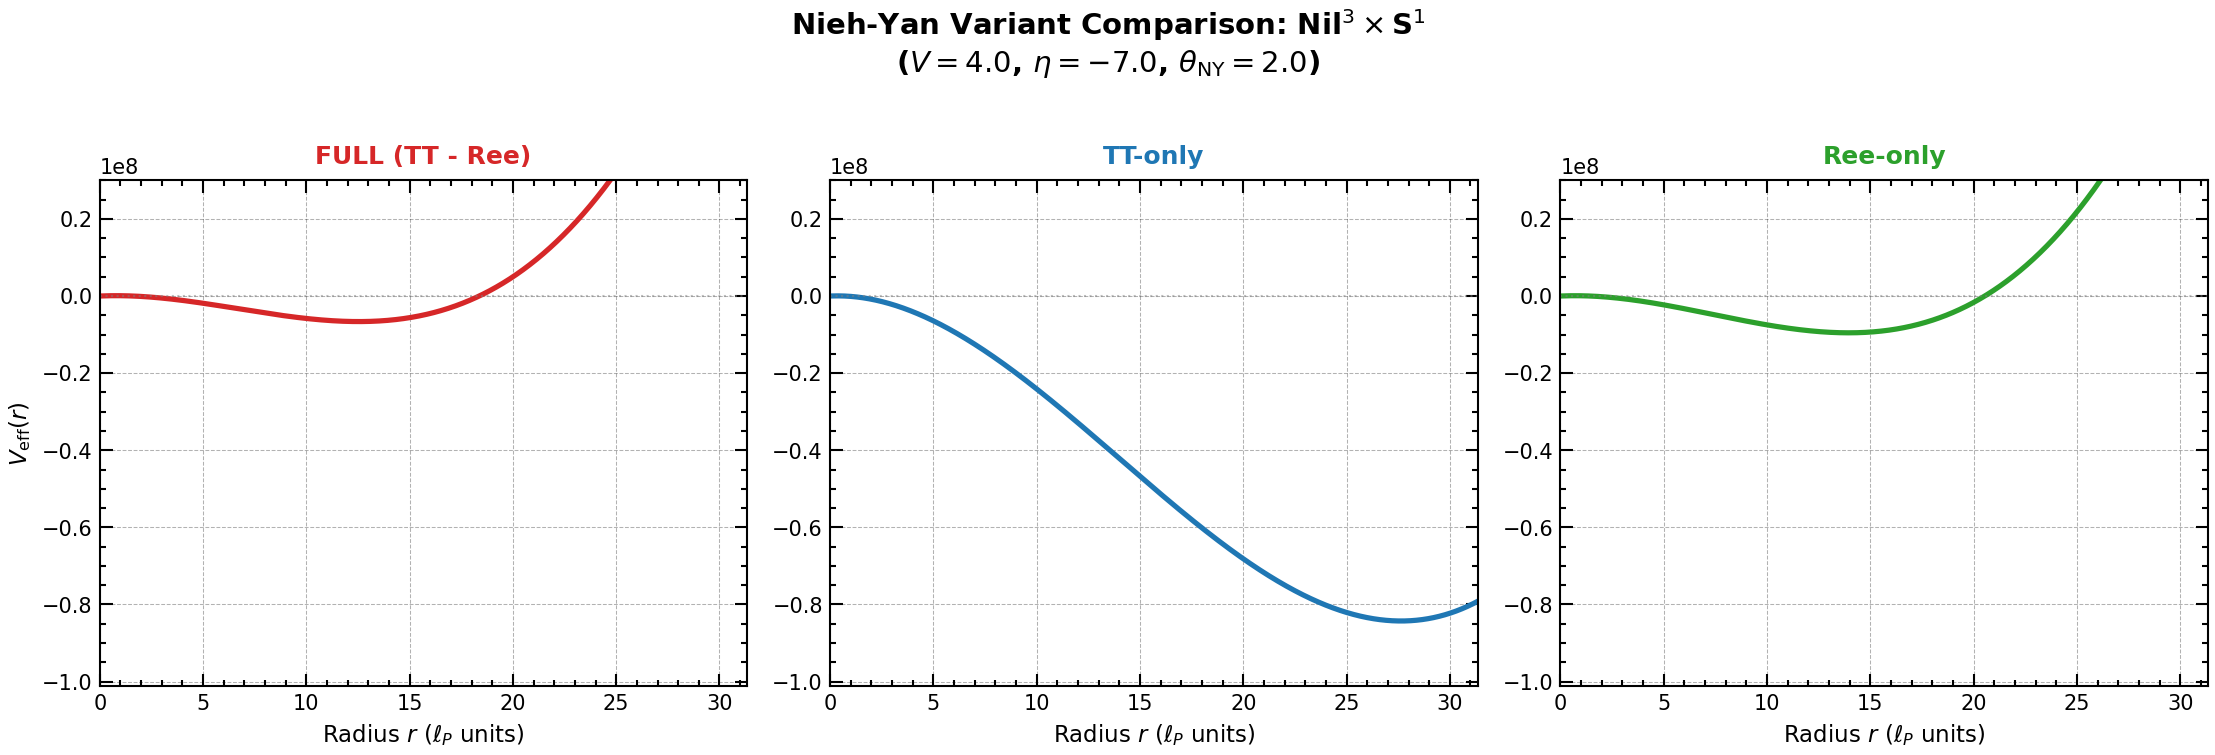

✓ T$^3\times$S$^1$ variant comparison saved: variant_comparison_T3.png/pdf
    Display range: x=[0, 33.3], r₀=13.31


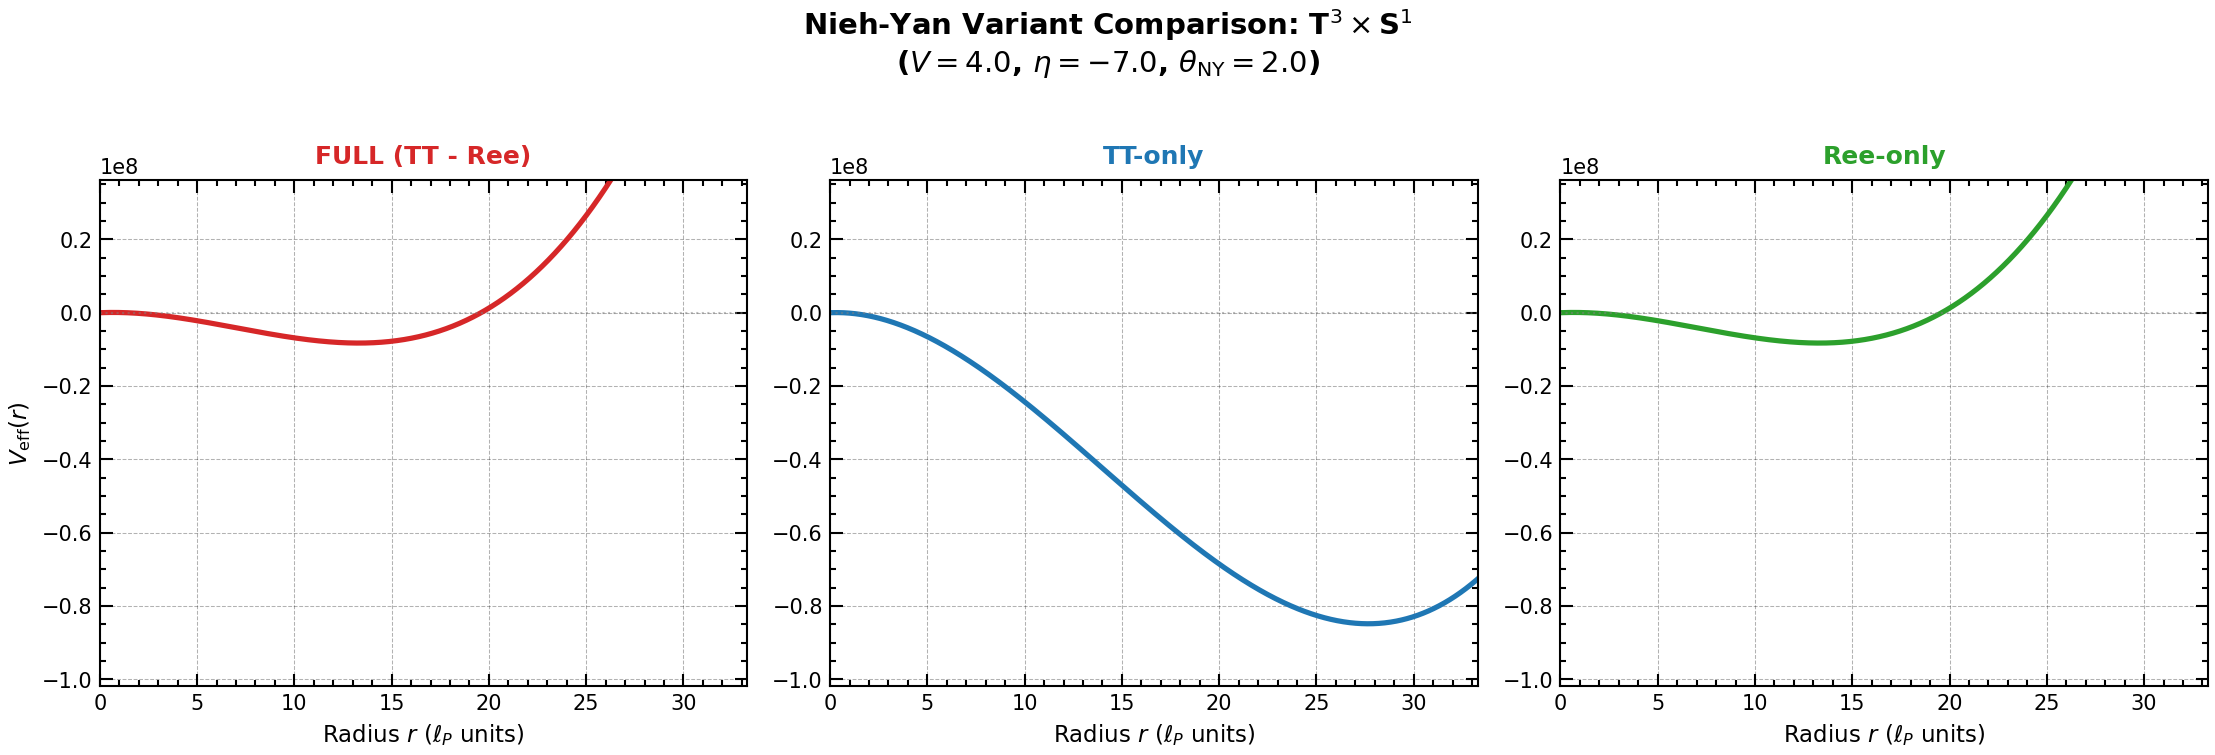


✓ All Variant Comparison figures generated


In [ ]:
# Cell 14: Generate Variant Comparison (3-panel layout per Topology)

# Color scheme for variants
variant_colors = {
    'FULL': '#D62728',    # Red (main result)
    'TT': '#1F77B4',      # Blue
    'REE': '#2CA02C'      # Green
}

variant_labels = {
    'FULL': 'FULL (TT - Ree)',
    'TT': 'TT-only',
    'REE': 'Ree-only'
}

topology_labels = {
    'S3': r'S$^3\times$S$^1$',
    'Nil3': r'Nil$^3\times$S$^1$',
    'T3': r'T$^3\times$S$^1$'
}

file_names = {
    'S3': 'variant_comparison_S3',
    'Nil3': 'variant_comparison_Nil3',
    'T3': 'variant_comparison_T3'
}

topologies = ['S3', 'Nil3', 'T3']
variants = ['FULL', 'TT', 'REE']

for topo in topologies:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Determine axis limits based on FULL variant's stable point
    stability = variant_stability[topo]
    r0, V_min = stability[0], stability[1]
    
    if r0 is not None:
        # Set x range: 0 to 2.5 * r0
        x_max = min(r0 * 2.5, 40.0)
        
        # Find y range: include all variants within x range
        mask = r_var <= x_max
        all_values = []
        for var in variants:
            all_values.extend(variant_data[topo][var][mask])
        
        y_min = min(all_values) * 1.2 if min(all_values) < 0 else min(all_values) * 0.8
        y_max = max(0, max(all_values) * 0.3)  # Include 0 line
        if y_max - y_min < abs(V_min):
            y_max = abs(V_min) * 0.5
    else:
        x_max = 25.0
        y_min, y_max = None, None
    
    # Plot each variant in separate panel
    for j, var in enumerate(variants):
        ax = axes[j]
        
        ax.plot(r_var, variant_data[topo][var], 
               color=variant_colors[var], linewidth=2.5)
        
        ax.axhline(0, color='gray', linestyle=':', alpha=0.5, linewidth=1)
        
        ax.set_xlabel(r"Radius $r$ ($\ell_P$ units)", fontsize=11)
        if j == 0:
            ax.set_ylabel(r"$V_{\mathrm{eff}}(r)$", fontsize=11)
        
        ax.set_title(variant_labels[var], fontsize=12, fontweight='bold', 
                    color=variant_colors[var], pad=8)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Apply axis limits (same for all panels)
        ax.set_xlim(0, x_max)
        if y_min is not None and y_max is not None:
            ax.set_ylim(y_min, y_max)
    
    plt.suptitle(f"Nieh-Yan Variant Comparison: {topology_labels[topo]}\n" +
                r"($V=4.0$, $\eta=-7.0$, $\theta_{\mathrm{NY}}=2.0$)",
                fontsize=14, y=1.02, fontweight='bold')
    plt.tight_layout()
    
    # Save
    fig.savefig(f'{file_names[topo]}.png', dpi=300, bbox_inches='tight')
    fig.savefig(f'{file_names[topo]}.pdf', bbox_inches='tight')
    
    print(f"✓ {topology_labels[topo]} variant comparison saved: {file_names[topo]}.png/pdf")
    print(f"    Display range: x=[0, {x_max:.1f}], r₀={r0:.2f}" if r0 else f"    Display range: x=[0, {x_max:.1f}], no stable point")
    plt.show()

print("\n✓ All Variant Comparison figures generated")